In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import regularizers

from sklearn.metrics import mean_absolute_error, mean_squared_error

tf.__version__

2023-03-24 19:31:24.751680: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 19:31:24.947882: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-24 19:31:25.731312: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-24 19:31:25.731408: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

'2.11.0'

In [2]:
# Load dataset
#csv_file = '../Dataset/dataset.csv'
#csv_file = '../Dataset/dataset_augmented.csv'
#csv_file = '../Dataset/dataset_left.csv'
csv_file = '../Dataset/dataset_left_new.csv'
dataframe = pd.read_csv(csv_file)
dataframe = dataframe.drop(dataframe.columns[0],axis=1) # remove first column (no information there)
dataframe.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,R,lambd
0,0,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,484.4822,350.23
1,3,3,0,0,0,0,0,1,2,0,0,0,0,0,0,0,644.6140,364.11
2,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,630.3364,347.10
3,0,1,0,0,4,0,0,0,0,4,0,3,0,0,0,0,392.8587,358.78
4,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,698.8705,344.20


In [3]:
# Create a target variable
dataframe['target'] = dataframe['R']

# Drop unused features.
dataframe = dataframe.drop(columns=['R', 'lambd'])
dataframe.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,target
0,0,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,484.4822
1,3,3,0,0,0,0,0,1,2,0,0,0,0,0,0,0,644.6140
2,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,630.3364
3,0,1,0,0,4,0,0,0,0,4,0,3,0,0,0,0,392.8587
4,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,698.8705


In [4]:
# Check overal statistis of each input feature 
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,170.0,0.600000,1.242254,0.0000,0.000000,0.0000,0.00000,4.0000
Pos2,170.0,0.623529,1.240123,0.0000,0.000000,0.0000,0.00000,4.0000
Pos3,170.0,0.570588,1.234736,0.0000,0.000000,0.0000,0.00000,4.0000
Pos4,170.0,0.511765,1.177894,0.0000,0.000000,0.0000,0.00000,4.0000
Pos5,170.0,0.547059,1.136077,0.0000,0.000000,0.0000,0.00000,4.0000
Pos6,170.0,0.423529,1.064505,0.0000,0.000000,0.0000,0.00000,4.0000
Pos7,170.0,0.376471,1.037481,0.0000,0.000000,0.0000,0.00000,4.0000
Pos8,170.0,0.470588,1.083368,0.0000,0.000000,0.0000,0.00000,4.0000
Pos9,170.0,0.305882,0.856904,0.0000,0.000000,0.0000,0.00000,4.0000
Pos10,170.0,0.258824,0.851771,0.0000,0.000000,0.0000,0.00000,4.0000


In [5]:
# normalize numerical targets

R_mean = dataframe['target'].mean()
R_std = dataframe['target'].std()

dataset = dataframe.copy()

dataset['target']=(dataset['target']-R_mean)/R_std

# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,170.0,6.000000e-01,1.242254,0.000000,0.000000,0.000000,0.000000,4.000000
Pos2,170.0,6.235294e-01,1.240123,0.000000,0.000000,0.000000,0.000000,4.000000
Pos3,170.0,5.705882e-01,1.234736,0.000000,0.000000,0.000000,0.000000,4.000000
Pos4,170.0,5.117647e-01,1.177894,0.000000,0.000000,0.000000,0.000000,4.000000
Pos5,170.0,5.470588e-01,1.136077,0.000000,0.000000,0.000000,0.000000,4.000000
Pos6,170.0,4.235294e-01,1.064505,0.000000,0.000000,0.000000,0.000000,4.000000
Pos7,170.0,3.764706e-01,1.037481,0.000000,0.000000,0.000000,0.000000,4.000000
Pos8,170.0,4.705882e-01,1.083368,0.000000,0.000000,0.000000,0.000000,4.000000
Pos9,170.0,3.058824e-01,0.856904,0.000000,0.000000,0.000000,0.000000,4.000000
Pos10,170.0,2.588235e-01,0.851771,0.000000,0.000000,0.000000,0.000000,4.000000


In [6]:
# Shuffle the dataset
dataset = dataset.sample(frac=1,random_state=39).reset_index(drop=True)

# Split the dataframe into training, validation, and test sets

### IMPORTANT: Select for normalization
#train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])
train, val, test = np.split(dataset.sample(frac=1), [int(0.8*len(dataset)), int(0.9*len(dataset))])
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

136 training examples
17 validation examples
17 test examples


In [7]:
# Create an input pipeline using tf.data

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

# Example: 
batch_size = 1
train_ds = df_to_dataset(train, batch_size=batch_size)

[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of Pos1:', train_features['Pos1'])
print('A batch of targets (R):', label_batch )

Every feature: ['Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15', 'Pos16', 'target']
A batch of Pos1: tf.Tensor([[0]], shape=(1, 1), dtype=int64)
A batch of targets (R): tf.Tensor([0.31341741], shape=(1,), dtype=float64)


/tmp/ipykernel_48549/3198051929.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
2023-03-24 19:31:41.851639: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-24 19:31:41.905856: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-03-24 19:31:41.905882: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guid

In [8]:
# Numerical columns preprocessing layer

def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [9]:
# Categorical columns preprocessing layer

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [10]:
# Create an input pipeline
batch_size = 2
# shuffle is set to False, as it was already done before
#train_ds = df_to_dataset(train, batch_size=batch_size)
train_ds = df_to_dataset(train, shuffle=False, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

/tmp/ipykernel_48549/3198051929.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_48549/3198051929.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [11]:
# Preprocess selected features (categorical and numerical)

all_inputs = []
encoded_features = []

# Multi-hot encoding and add the resulting feature inputs to encoded_features
categorical_cols = ['Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 
                    'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 
                    'Pos13', 'Pos14', 'Pos15', 'Pos16']
#categorical_cols= list(train_features.keys())
#categorical_cols = categorical_cols[0:16]
print("Categorical cols: "+str(categorical_cols))
for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='int64',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

# Normalize numerical features.
""" numeric_cols = ['X', 'Y', 'Z']
print("Numerical cols: "+str(numeric_cols))
for header in numeric_cols:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col) """

""" numeric_cols = ['target']
print("Numerical cols: "+str(numeric_cols))
for header in numeric_cols:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col) """

Categorical cols: ['Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15', 'Pos16']
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


' numeric_cols = [\'target\']\nprint("Numerical cols: "+str(numeric_cols))\nfor header in numeric_cols:\n  numeric_col = tf.keras.Input(shape=(1,), name=header)\n  normalization_layer = get_normalization_layer(header, train_ds)\n  encoded_numeric_col = normalization_layer(numeric_col)\n  all_inputs.append(numeric_col)\n  encoded_features.append(encoded_numeric_col) '

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Pos1 (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Pos2 (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Pos3 (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Pos4 (InputLayer)              [(None, 1)]          0           []                               
                                                                                              

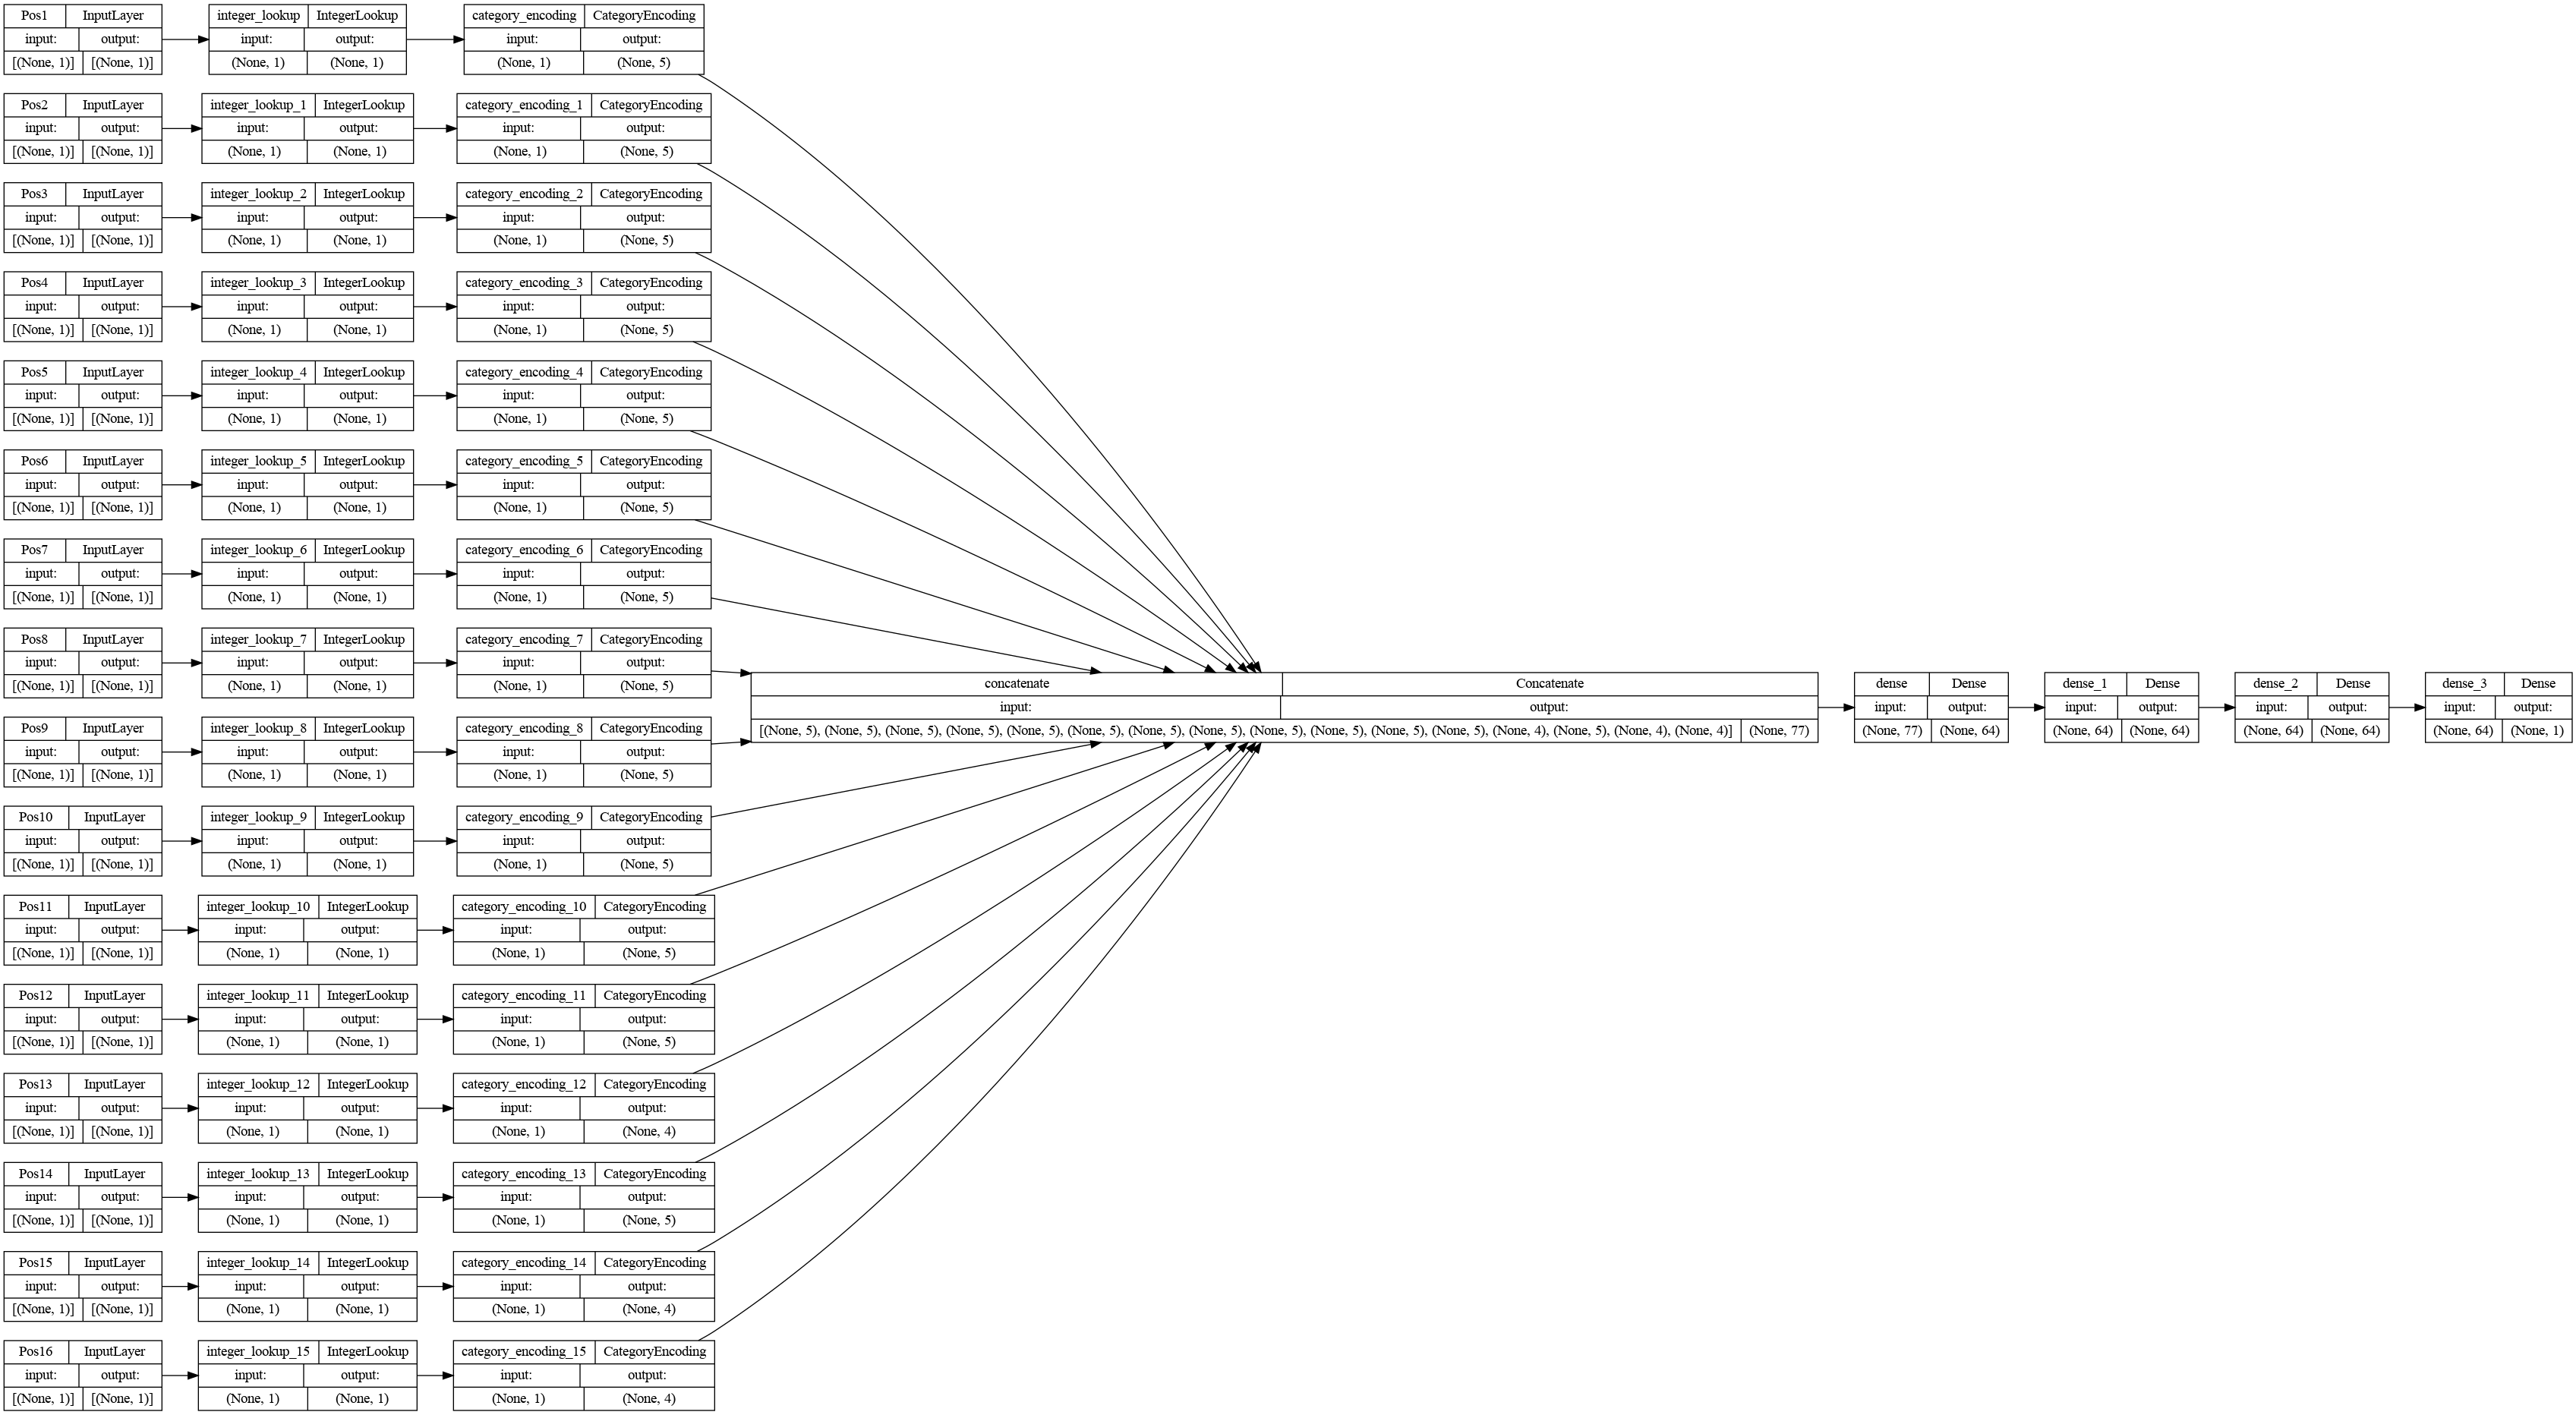

In [12]:
# Create the model architecture
all_features = tf.keras.layers.concatenate(encoded_features)

# tiny model
#x = tf.keras.layers.Dense(8, activation="relu")(all_features)

# small model 
#x = tf.keras.layers.Dense(16, activation="relu")(all_features)
#x = tf.keras.layers.Dense(16, activation="relu")(x)

# medium model
x = tf.keras.layers.Dense(64, activation="relu")(all_features)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)

# large model
#x = tf.keras.layers.Dense(512, activation="relu")(all_features)
#x = tf.keras.layers.Dense(512, activation="relu")(x)
#x = tf.keras.layers.Dense(512, activation="relu")(x)
#x = tf.keras.layers.Dense(512, activation="relu")(x)

# large model with L2-regularization and dropout
""" x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x) """

output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)
model.summary()

#loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001)
# compile the model
model.compile(#optimizer='adam',
              #loss='mean_absolute_error',
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              loss=tf.keras.losses.MeanAbsoluteError(),
              optimizer=tf.keras.optimizers.Adam(0.0001)
              #optimizer=tf.keras.optimizers.Adam(0.001),
              #metrics=["accuracy"])
)

tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


In [13]:
# Train the model
history = model.fit(train_ds, epochs=100, verbose=2, validation_data=val_ds)


Epoch 1/100


/home/alfonso/Work/UGR/Calculations/Helicenes_GNNs/Helicenes_venv/lib/python3.10/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


68/68 - 1s - loss: 0.7879 - val_loss: 0.7928 - 1s/epoch - 20ms/step
Epoch 2/100
68/68 - 0s - loss: 0.7708 - val_loss: 0.7884 - 75ms/epoch - 1ms/step
Epoch 3/100
68/68 - 0s - loss: 0.7554 - val_loss: 0.7812 - 113ms/epoch - 2ms/step
Epoch 4/100
68/68 - 0s - loss: 0.7385 - val_loss: 0.7751 - 78ms/epoch - 1ms/step
Epoch 5/100
68/68 - 0s - loss: 0.7207 - val_loss: 0.7675 - 82ms/epoch - 1ms/step
Epoch 6/100
68/68 - 0s - loss: 0.7006 - val_loss: 0.7589 - 78ms/epoch - 1ms/step
Epoch 7/100
68/68 - 0s - loss: 0.6832 - val_loss: 0.7539 - 73ms/epoch - 1ms/step
Epoch 8/100
68/68 - 0s - loss: 0.6610 - val_loss: 0.7571 - 74ms/epoch - 1ms/step
Epoch 9/100
68/68 - 0s - loss: 0.6386 - val_loss: 0.7489 - 87ms/epoch - 1ms/step
Epoch 10/100
68/68 - 0s - loss: 0.6133 - val_loss: 0.7494 - 80ms/epoch - 1ms/step
Epoch 11/100
68/68 - 0s - loss: 0.5852 - val_loss: 0.7479 - 79ms/epoch - 1ms/step
Epoch 12/100
68/68 - 0s - loss: 0.5621 - val_loss: 0.7345 - 76ms/epoch - 1ms/step
Epoch 13/100
68/68 - 0s - loss: 0.539

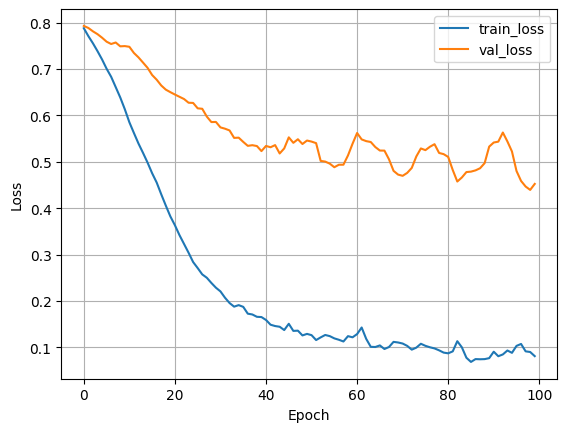

In [14]:
# Plot the loss

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

In [15]:
def plot_PredvsTrue(y_true, y_pred, n_stds=2):

    plt.figure(figsize=(3, 3), dpi=200)
    p1 = min(y_true)
    p2 = max(y_true)
    #p1 = 0
    #p2 = 64
    #p1 = max(max(y_pred), max(y_true))
    #p2 = min(min(y_pred), min(y_true))
    plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
    plt.scatter(y_true,y_pred,color="blue",label="Model",s=6)
    plt.xlabel('True',fontsize=15)
    plt.ylabel('Pred',fontsize=15)
    plt.legend(loc="upper left")
    plt.show()

9/9 [==============================] - 0s 1ms/step
(17, 1)
(17, 1)


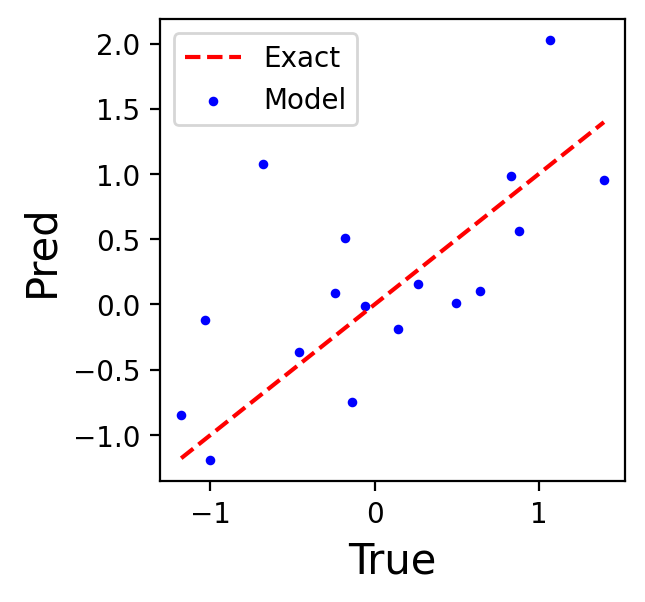

Test MAE: 0.4885968983057533


In [16]:
# Pred vs True values on test set 

y_pred = model.predict(test_ds)
y_pred.shape
y_true = np.zeros((len(test['target']),1))
y_true[:,0] = test['target']

print(y_true.shape)
print(y_pred.shape)
#print(y_true)
#print(y_pred)

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
print("Test MAE: "+str(test_mae))

68/68 [==============================] - 0s 935us/step
(136, 1)
(136, 1)


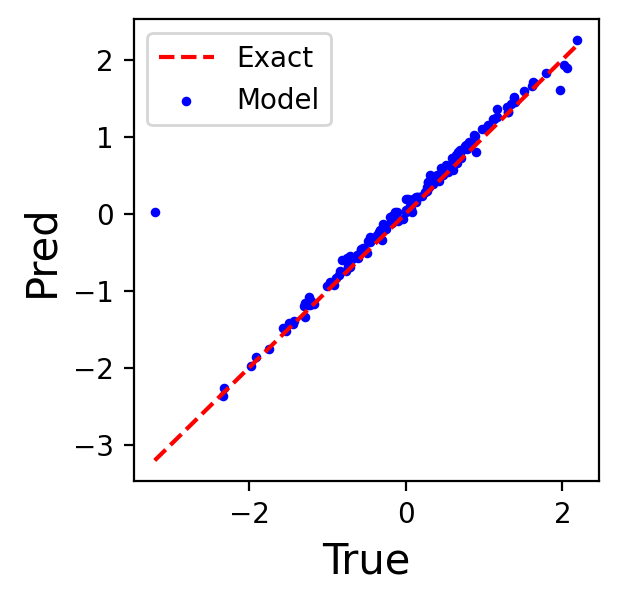

Train MAE: 0.10662603912597325


In [17]:
# Pred vs True values on training set 

y_pred = model.predict(train_ds)
y_pred.shape
y_true = np.zeros((len(train['target']),1))
y_true[:,0] = train['target']

print(y_true.shape)
print(y_pred.shape)
#print(y_true)
#print(y_pred)

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
print("Train MAE: "+str(test_mae))

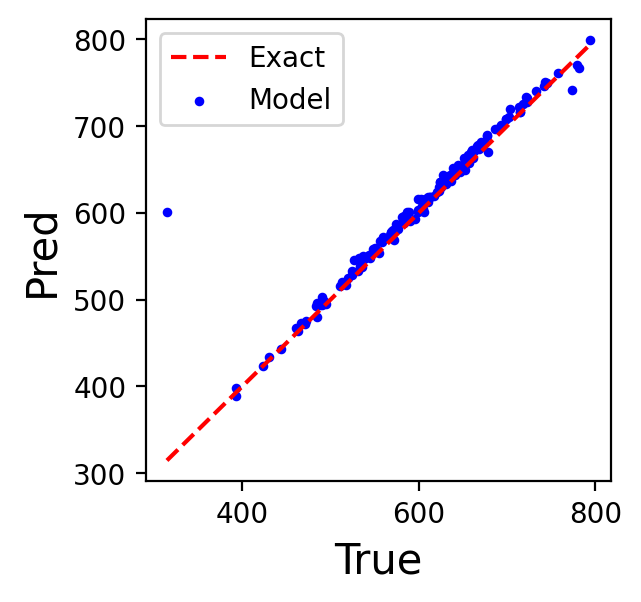

Train MAE (non-normalized): 9.456343170166013


In [18]:
# Evaluate the model with non-normalized units

y_true = y_true * R_std + R_mean
y_pred = y_pred * R_std + R_mean

#print("True: "+str(y_true))
#print("Pred: "+str(y_pred))

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
print("Train MAE (non-normalized): "+str(test_mae))

In [65]:
# save model

#model.save('R_model_good_tiny')
#model.save('R_model_good_small')
#model.save('R_model_good_medium')
#model.save('R_model_good_large')
#reloaded_model = tf.keras.models.load_model('R_model')

INFO:tensorflow:Assets written to: R_model_good_medium/assets


INFO:tensorflow:Assets written to: R_model_good_medium/assets


9/9 [==============================] - 0s 1ms/step


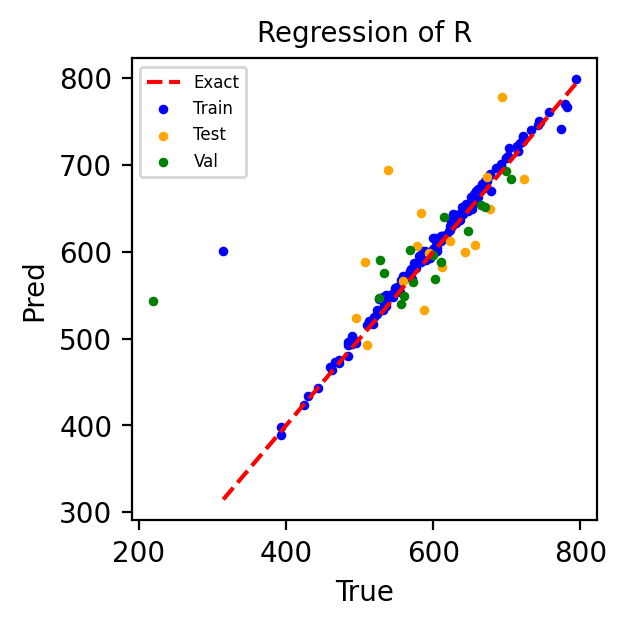

train MAE (non-normalized): 9.456343170166013
test MAE (non-normalized): 43.33221956571691
val MAE (non-normalized): 40.12203459903494


In [19]:
# Evaluate the model with non-normalized units on the whole dataset

y_pred_test = model.predict(test_ds)
y_true_test = np.zeros((len(test['target']),1))
y_true_test[:,0] = test['target']

y_pred_train = model.predict(train_ds)
y_true_train = np.zeros((len(train['target']),1))
y_true_train[:,0] = train['target']

y_pred_val = model.predict(val_ds)
y_true_val = np.zeros((len(val['target']),1))
y_true_val[:,0] = val['target']

y_true_test = y_true_test * R_std + R_mean
y_pred_test = y_pred_test * R_std + R_mean
y_true_test = y_true_test.ravel()
y_pred_test = y_pred_test.ravel()

y_true_train = y_true_train * R_std + R_mean
y_pred_train = y_pred_train * R_std + R_mean
y_true_train = y_true_train.ravel()
y_pred_train = y_pred_train.ravel()

y_true_val = y_true_val * R_std + R_mean
y_pred_val = y_pred_val * R_std + R_mean
y_true_val = y_true_val.ravel()
y_pred_val = y_pred_val.ravel()

plt.figure(figsize=(3, 3), dpi=200)
plt.title("Regression of R",fontsize=10)
p1 = min(y_true_train)
p2 = max(y_true_train)
plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
plt.scatter(y_true_train,y_pred_train,color="blue",label="Train",s=6)
plt.scatter(y_true_test,y_pred_test,color="orange",label="Test",s=6)
plt.scatter(y_true_val,y_pred_val,color="green",label="Val",s=6)
plt.xlabel('True',fontsize=10)
plt.ylabel('Pred',fontsize=10)
plt.legend(loc="upper left",prop={'size': 6})
plt.show()

train_mae = mean_absolute_error(y_true_train,y_pred_train)
print("train MAE (non-normalized): "+str(train_mae))
test_mae = mean_absolute_error(y_true_test,y_pred_test)
print("test MAE (non-normalized): "+str(test_mae))
val_mae = mean_absolute_error(y_true_val,y_pred_val)
print("val MAE (non-normalized): "+str(val_mae))

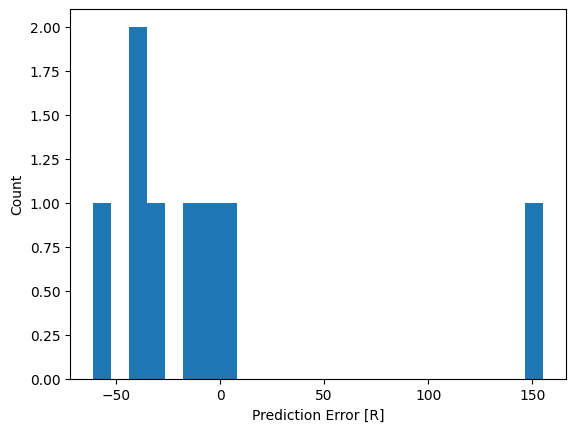

In [22]:
# Error distribution
error = y_pred_test - y_true_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [R]')
_ = plt.ylabel('Count')


In [23]:
y_pred = np.concatenate((y_pred_train,y_pred_test,y_pred_val))
y_true = np.concatenate((y_true_train,y_true_test,y_true_val))
#print(y_true.shape)
#print(y_pred.shape)
#print(y_true)
#print(y_pred)
y_true = y_true.ravel()
y_pred = y_pred.ravel()
#print("True: "+str(y_true))
#print("Pred: "+str(y_pred))

# explore data

data = dataset.to_numpy()

#print()
print("Data id, nº halogens, y_true, y_pred, abs(y_pred-y_true)")

error_nhalogens = np.zeros(4)
num_nhalogens = np.zeros(4)
error_halogentype = np.zeros(4)
num_halogentype = np.zeros(4)

for i in range(len(y_pred)):
    diff = abs(y_pred[i]-y_true[i])
    x_data = data[i,0:15]
    n_halogens = np.count_nonzero(x_data)
    #print(data[i,0:15])
    #print(n_halogens)

    error_nhalogens[n_halogens-1] = error_nhalogens[n_halogens-1] + diff
    num_nhalogens[n_halogens-1] = num_nhalogens[n_halogens-1] + 1

    print(str(i)+"  "+str(n_halogens)+"  "+str(y_true[i])+"  "+str(y_pred[i])+"  "+str(diff))


error_nhalogens[:] = error_nhalogens[:] / num_nhalogens[:]
print()
print("Mean Absolute Error (MAE) according to nº halogens: 1 halogen, 2 halogens, 3 halogens, 4 halogens")
print(error_nhalogens)

Data id, nº halogens, y_true, y_pred, abs(y_pred-y_true)
0  3  838.6846  861.97375  23.289154882812454
1  2  911.7212  904.6262  7.094979296874953
2  2  794.8221  814.4658  19.643720312500022
3  3  867.9379  875.56366  7.625759667968737
4  1  901.385  891.20746  10.177541503906241
5  4  685.3683  734.6754  49.30711503906252
6  1  623.8919  690.2098  66.31787783203129
7  2  866.5245  872.50555  5.981054199218761
8  2  1043.2995  1033.1694  10.13006640625008
9  4  911.9816  906.1483  5.833284570312458
10  3  917.2814  906.9863  10.295071874999962
11  2  794.7733  820.7395  25.96620195312505
12  4  874.7182  878.4907  3.7725226562499756
13  3  778.645  803.6498  25.004780273437518
14  3  808.3724  828.5398  20.16739492187503
15  3  881.7939  878.78906  3.004837500000008
16  2  792.4768  819.4483  26.971503222656224
17  3  855.9025  866.22  10.317470703124968
18  4  890.7995  886.13983  4.659668457031216
19  2  962.5692  956.94617  5.6230330078125235
20  1  853.1408  854.8725  1.7316975585